# NLP Assignment 2: Vector Space Semantics for Similarity between Friends Characters

In [24]:
!pip install nltk

In [25]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math
import nltk
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [26]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


# Q3. Add dialogue context and scene features (15 marks)

**Solution 3-**

Adjusted the method `create_character_document_from_dataframe` which aims to generate character documents with context by joining each character's lines into a single string and including lines spoken by other characters in the same scene as context.
The method involves Grouping by Episodes and Scenes, Iterating Over Episodes and Scenes, Iterating Over Characters in the Scene, Processing Each Character's Lines, Processing Context Lines, Combining Character's Lines with Context.


Hence, it incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene.



In [27]:
def create_character_document_from_dataframe(df, max_lines_per_character, context_size=5):
    character_documents = {}
    character_line_count = {}

    # Group DataFrame by episode and scene
    grouped_episodes_scenes = df.groupby(['Episode', 'Scene'])

    # Iterate over each episode and scene
    for (episode, scene), group in grouped_episodes_scenes:
        # Iterate over each character in the scene
        for character_name, character_lines_group in group.dropna(subset=['Line']).groupby('Character_name'):
            if character_name not in character_documents:
                character_documents[character_name] = ""
                character_line_count[character_name] = 0

            # Check if the character has reached the maximum line count
            if character_line_count[character_name] >= max_lines_per_character:
                continue

            # Iterate over each line in the character's lines group
            for line_index in character_lines_group.index:
                # Get context lines (limited by context_size)
                # Ensure the context is from the same scene and does not include the character's own lines
                character_line_count[character_name] += 1

                # Check if the character has reached the maximum line count
                if character_line_count[character_name] >= max_lines_per_character:
                    break

                # Get context lines before and after the current line
                context_before = group.loc[(group.index < line_index) & (group['Character_name'] != character_name)].tail(context_size)['Line'].dropna().astype(str).tolist()
                context_after = group.loc[(group.index > line_index) & (group['Character_name'] != character_name)].head(context_size)['Line'].dropna().astype(str).tolist()

                # Combine context lines with "EOL" (end-of-line) separators
                context = " EOL ".join(context_before + context_after)

                # Combine character's own lines with context and add special markers
                character_lines = " EOL ".join(character_lines_group.loc[line_index].astype(str).tolist())
                character_documents[character_name] += character_lines + " CONTEXT_START " + context + " CONTEXT_END "

    print("Lines per character:", character_line_count)
    return character_documents


In [28]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_lines_per_character=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

Lines per character: {'#ALL#': 300, 'Chandler Bing': 300, 'Joey Tribbiani': 300, 'Monica Geller': 300, 'Other_None': 300, 'Phoebe Buffay': 300, 'Rachel Green': 300, 'Ross Geller': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

#ALL# Number of Words:  32349
Chandler Bing Number of Words:  29734
Joey Tribbiani Number of Words:  31753
Monica Geller Number of Words:  32742
Other_None Number of Words:  28885
Phoebe Buffay Number of Words:  31236
Rachel Green Number of Words:  32927
Ross Geller Number of Words:  29297
Other_Female Number of Words:  33053
Other_Male Number of Words:  30795
total words 312771


# Q1. Improve pre-processing (20 marks)

**Solution 1-** As part of question 1, I have added extra steps to tokenise and filter out the unwanted tokens. The techniques I have tried are as follows:-
1. **Lowercasing** - This will convert each doc of corpus into lower case.
2. **Tokenization** - Using `word_tokenize` to generate tokens for the character text.
3. **Punctuation Removal** - This will remove any punctuation in the character text.
4. **Stopwords Removal** - This will remove stopwords include common words such as "the," "and," "is," "in," and so on.
5. **Stemming** - This will reduce words to their base or root form. It involves removing suffixes from words to obtain a common base form.
6. **Special Character Removal** - This involves eliminating non-alphabetic characters.
7. **Handling Contractions** - Handling contractions involves expanding contractions in text. For example, converting "don't" to "do not" or "I'll" to "I will."
8. **Removing HTML Tags and URLs** - Removing HTML tags and URLs involves eliminating HTML tags and web links from text data.
9. **Handling Accented Characters** - It involves converting accented characters (e.g., é, ü) to their non-accented counterparts (e.g., e, u).
10. **Handling Rare Words** - It removes words that appear only once.
11. **Lemmatization** - It reduce words to their base or dictionary form (lemma). Unlike stemming, lemmatization considers the context and aims to transform words to their canonical or meaningful base form.

The mean value before was 4.2 for validation set and 4.0 for testing set.
The mean value after is 3.8 for validation set and 3.3 for testing set.


In [29]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    ::character_text:: a string with all of one character's lines
    """
    # Lowercasing
    character_text = character_text.lower()

    # Tokenization
    tokens = word_tokenize(character_text)

    # Removing Punctuation
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # # Stemming
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]

    # Removing Special Characters and Numbers
    tokens = [re.sub(r'[^a-zA-Z\s]', '', token) for token in tokens]

    # Handling Contractions (basic example)
    tokens = [re.sub(r"n't", ' not', token) for token in tokens]

    # Removing HTML Tags and URLs
    tokens = [re.sub(r'<[^>]+>', '', token) for token in tokens]
    tokens = [re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', token) for token in tokens]

    # Handling Accented Characters
    tokens = [re.sub(r'[^\x00-\x7F]+', '', token) for token in tokens]

    # Handling Rare Words (remove words that appear only once)
    word_counts = Counter(tokens)
    tokens = [token for token in tokens if word_counts[token] > 1]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens


# Example Usage:
raw_text = "This is a text with some contractions, special special characters, and numbers 123. It's not good but not bad."
preprocessed_text = pre_process(raw_text)
print("Raw Text:")
print(raw_text)
print("\nPreprocessed Text:")
print(preprocessed_text)

Raw Text:
This is a text with some contractions, special special characters, and numbers 123. It's not good but not bad.

Preprocessed Text:
['', 'special', 'special', '', '', '']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Q2. Improve linguistic feature extraction (30 marks)
## **Solution 2- To improve the linguistic feature extraction I have added few techniques which are as follows:-**

## Optemization in **to_feature_vector_dictionary** Method
It includes adding basic features like `length`, `number of words`, and `average word length` for the character doc in corpus. Post that I added `N-gram` where I have used `Bi-gram`, `Tri-gram`, `Tetra-gram`. Another technique I used is `POS tagging` which can be called using the function `get_pos_tags`. This function takes a piece of text as input, tokenizes it into words, and then performs part-of-speech (POS) tagging on those words using the NLTK library. It returns a list of POS tags for each word in the text.

The function `to_feature_vector_dictionary` takes a list of pre-processed tokens (character_doc) and a list of extra features (extra_features). It creates a dictionary (features) to represent the feature vector for the character.

## Optemization in **create_document_matrix_from_corpus** Method
The function, `create_document_matrix_from_corpus`, is designed to create a feature matrix from a given corpus using different vectorization techniques and feature selection. It include techniques like `TF-IDF` and `k-best selection`.

This section handles the fitting or transforming of the documents based on the value of the fitting parameter:

- If fitting is True, it means this is the training phase, and the vectorizer (corpusVectorizer) and feature selector (selector_fm) need to be fitted on the training data. It fits the vectorizer and transforms the documents using both the vectorizer and feature selector.

- If fitting is False, it means this is the testing or validation phase. It only transforms the documents using the pre-fitted vectorizer and feature selector.

The function returns the transformed feature matrix (doc_feature_matrix_after), the fitted vectorizer (corpusVectorizer), and the fitted feature selector (selector_fm). This allows you to use the same fitted vectorizer and feature selector when transforming new data during the testing or validation phase.

**The performance metrics before for validation set was :-**
- mean rank 3.8
- mean cosine similarity 0.990134754654987
- 3 correct out of 10 / accuracy: 0.3

**The performance metrics before for testing set was :-**
- mean rank 3.3
- mean cosine similarity 0.989790382449
- 5 correct out of 10 / accuracy: 0.5

**The performance metrics after for validation set is :-**
- mean rank 4.8
- mean cosine similarity 0.062866284486955
- 2 correct out of 10 / accuracy: 0.2

**The performance metrics after for testing set is :-**
- mean rank 4.9
- mean cosine similarity 0.0777677971579
- 1 correct out of 10 / accuracy: 0.1


In [31]:
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

# Download NLTK data for POS tagging and sentiment analysis
import nltk
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

def to_feature_vector_dictionary(character_doc, extra_features=None):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Incorporates N-grams(1-4), POS tags, and few other features.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    # to check for non-empty input
    if not character_doc:
        return {"empty_document": 1}

    counts = Counter()

    features = {}
    features['length'] = len(character_doc)
    features['num_words'] = len(character_doc)
    features['average_word_length'] = sum(len(word) for word in character_doc) / max(1, features['num_words'])

    # N-grams (unigrams, bigrams, and trigrams, tetragram)
    n_gram_vector = CountVectorizer(ngram_range=(1, 4))
    n_gram_matrix = n_gram_vector.fit_transform([" ".join(character_doc)])
    n_gram_feature_names = n_gram_vector.get_feature_names_out()
    n_gram_dict = dict(zip(n_gram_feature_names, n_gram_matrix.toarray()[0]))

    #POS tags
    pos_tags = [tag for _, tag in pos_tag(character_doc)]
    pos_feature_dict = dict(zip(pos_tags, [1] * len(pos_tags)))

    #Combine all features
    counts.update(n_gram_dict)
    counts.update(pos_feature_dict)
    counts.update(features)

    #extra features
    if extra_features:
        for feature in extra_features:
            counts[feature] += 1

    return counts


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFpr

def create_document_matrix_from_corpus(corpus, corpusVectorizer, selector_fm, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently doing TF-IDF and K_best selector technique.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """

    if fitting:
        # Fit the TfidfVectorizer on the training data
        doc_feature_matrix = corpusVectorizer.fit_transform([' '.join(to_feature_vector_dictionary(doc, [])) for _, doc in corpus])
        doc_feature_matrix_after = selector_fm.fit_transform(doc_feature_matrix, [label for label, doc in corpus ])

    else:
        # Transform the documents into a TF-IDF feature matrix
        doc_feature_matrix = corpusVectorizer.transform([' '.join(to_feature_vector_dictionary(doc, [])) for _, doc in corpus])
        doc_feature_matrix_after = selector_fm.transform(doc_feature_matrix)

    return doc_feature_matrix_after, corpusVectorizer, selector_fm


vectorizer = TfidfVectorizer(min_df=5)
selector = SelectKBest(chi2, k='all')

training_feature_matrix, vectorizer_fit, selector_fit = create_document_matrix_from_corpus(training_corpus, vectorizer, selector, fitting=True)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [33]:
training_feature_matrix

<10x878 sparse matrix of type '<class 'numpy.float64'>'
	with 6749 stored elements in Compressed Sparse Row format>

In [34]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_lines_per_character=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

Lines per character: {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, '#ALL#': 18, 'Chandler Bing': 30, 'Joey Tribbiani': 30, 'Monica Geller': 30, 'Phoebe Buffay': 30, 'Ross Geller': 30, 'Other_Female': 30}
Num. Characters:  10 

Other_None Num of Words:  2516
Rachel Green Num of Words:  3036
Other_Male Num of Words:  2642
#ALL# Num of Words:  1930
Chandler Bing Num of Words:  2594
Joey Tribbiani Num of Words:  2347
Monica Geller Num of Words:  2480
Phoebe Buffay Num of Words:  2229
Ross Geller Num of Words:  2349
Other_Female Num of Words:  3447
total words 25570


In [35]:
val_feature_matrix, _, _ = create_document_matrix_from_corpus(val_corpus,vectorizer_fit, selector_fit, fitting=False)

In [36]:
val_feature_matrix

<10x878 sparse matrix of type '<class 'numpy.float64'>'
	with 1420 stored elements in Compressed Sparse Row format>

In [37]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    if norm(v1) == 0 or norm(v2) == 0:
        # Handle division by zero by returning 0 or another suitable value
        return 0.0

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [38]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [39]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [40]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.2
mean cosine similarity 0.9659802685491533
8 correct out of 10 / accuracy: 0.8


# Q5. Analyse the similarity results (10 marks)

**Solution-** We will refer `heat map` to identify the heldout character vectors ranked closest to each other character's training vector and those furthest away.

The **Chandler & Joey and Ross & Joey are the closest characters**, the reason being highest similarity of 0.96 and 0.962 respectively. This implies that **Chandler and Joey** exhibit resemblances in their language patterns, engage in similar topics, or have interactions that result in similar representations of their dialogue.


The Chandler & Rachel and Joey & Rachel are the furthest characters, the reason being highest similarity of 0.932 and 0.935 respectively.


Various linguistic and contextual factors, including dialogue context, vocabulary, topics, interactions with other characters, amount of dialogue, and speech style, should be considered to determine the highest match between the target character in the training set and their vector in the held-out set. It's important to acknowledge model limitations, such as the choice of features (e.g., n-grams) and the vectorization technique (e.g., TF-IDF), which may not effectively capture the nuances required for character distinction.


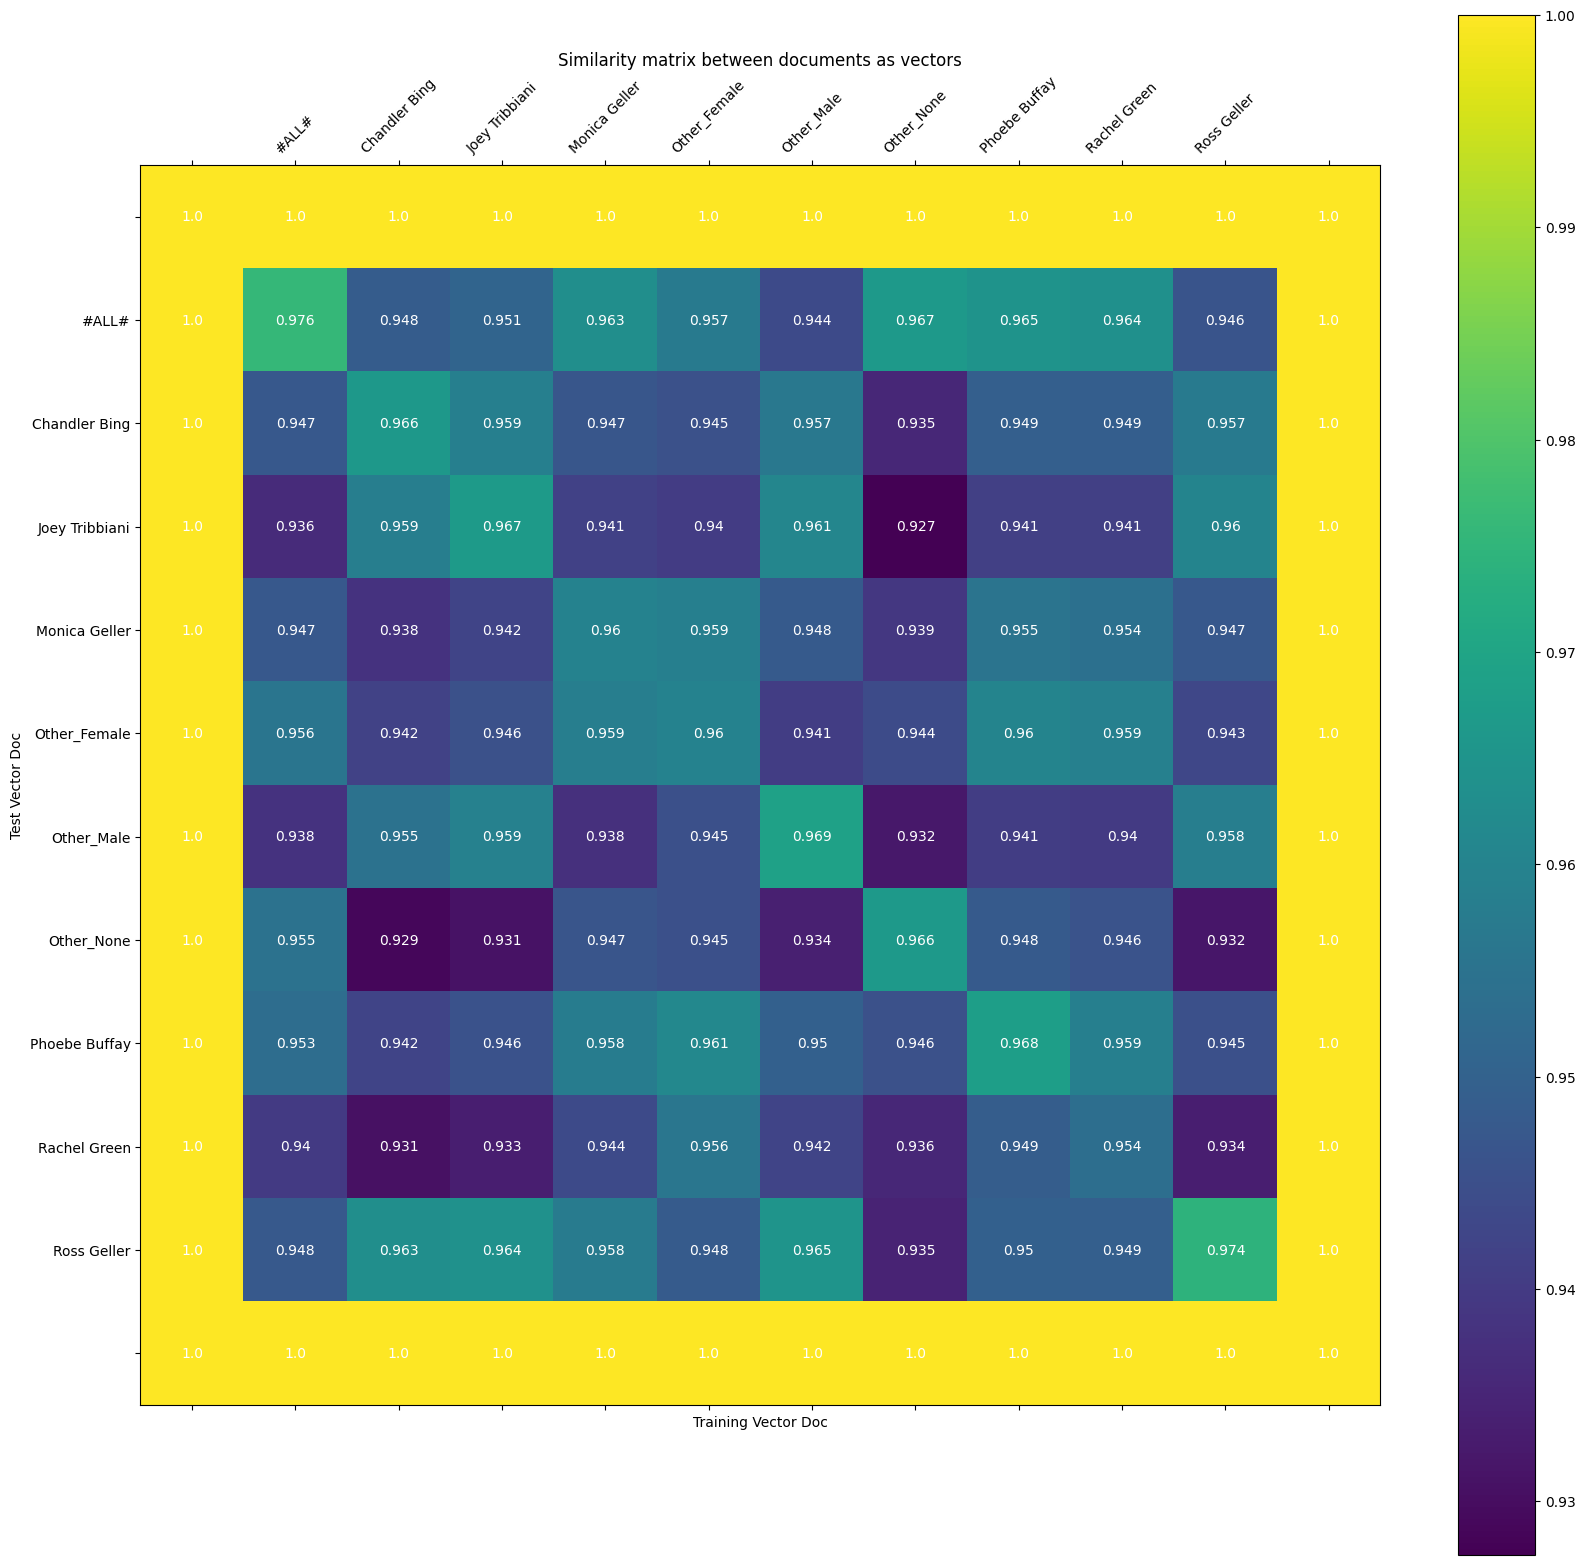

In [41]:
plot_heat_map_similarity(df)

# Q4. Parameter Search (15 marks)

Solution 4- It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more reliable results. The below code performs a `grid search` over a specified set of hyperparameters, attempting to find the combination that yields the best mean rank. It uses these hyperparameters to create a `TF-IDF vectorizer` and a `feature selector`, then evaluates the performance on a validation set. The best hyperparameters and their corresponding mean rank are printed at the end of the process.

The params taken for grid search are:-

param_grid = {
    'k_best': [chi2],
    'k_feature': [100, 200, 'all'],
    'mindf': [5,10]
}

- k_best method i am using is chi2.
- Feature for k_best will be 100, 200 and 'all'
- mindf is min_df for TfidfVectorizer

**Best hyperparametr that was found to be {'k_best': chi2, 'k_feature': 200, 'mindf': 5}**

In [42]:
from itertools import product
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

param_grid = {
    'k_best': [chi2],
    'k_feature': [100, 200, 'all'],
    'mindf': [5,10]
}

best_mean_rank = 5.0
best_params = {}

for params in product(*param_grid.values()):
  hype = dict(zip(param_grid.keys(), params))

  print(f'Running Grid Search for {hype}')
  k_best,k_feature,mindf = hype.values()
  try:
    initial_vectorizer = TfidfVectorizer(min_df=mindf)
    initial_selector = SelectKBest(k_best, k=k_feature)

    train_feature_matrix_gs, vectorizer_trained, selector_trained = create_document_matrix_from_corpus(training_corpus, initial_vectorizer, initial_selector, fitting=True)
    val_feature_matrix_gs,_,_ = create_document_matrix_from_corpus(val_corpus, vectorizer_trained, selector_trained, fitting=False)
  except:
    print(f'Error occurred for hyperparameter {hype}')

  mean_rank_gs, mean_cosine_simliarity_gs, acc_gs, df_gs = compute_IR_evaluation_scores(train_feature_matrix_gs, val_feature_matrix_gs, train_labels, val_labels)

  if mean_rank_gs < best_mean_rank:
    best_mean_rank = mean_rank_gs
    best_params = hype

print()
print("Best Accuracy", best_mean_rank)
print("Best Parameter", best_params)



Running Grid Search for {'k_best': <function chi2 at 0x7ff4bf6e1c60>, 'k_feature': 100, 'mindf': 5}
mean rank 1.2
mean cosine similarity 0.780081522584084
8 correct out of 10 / accuracy: 0.8
Running Grid Search for {'k_best': <function chi2 at 0x7ff4bf6e1c60>, 'k_feature': 100, 'mindf': 10}
mean rank 3.4
mean cosine similarity 0.850420072930827
3 correct out of 10 / accuracy: 0.3
Running Grid Search for {'k_best': <function chi2 at 0x7ff4bf6e1c60>, 'k_feature': 200, 'mindf': 5}
mean rank 1.1
mean cosine similarity 0.8270841383619759
9 correct out of 10 / accuracy: 0.9
Running Grid Search for {'k_best': <function chi2 at 0x7ff4bf6e1c60>, 'k_feature': 200, 'mindf': 10}
mean rank 4.2
mean cosine similarity 0.8356780732245823
2 correct out of 10 / accuracy: 0.2
Running Grid Search for {'k_best': <function chi2 at 0x7ff4bf6e1c60>, 'k_feature': 'all', 'mindf': 5}
mean rank 1.2
mean cosine similarity 0.9659802685491533
8 correct out of 10 / accuracy: 0.8
Running Grid Search for {'k_best': <fu

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 30 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **10**. Initially, the code in this template achieves a mean rank of **4.0**  and accuracy of **0.3** on the test set and a mean rank of **4.2** and accuracy of **0.1** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html.

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 30 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [43]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_lines_per_character=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = TfidfVectorizer(min_df=5)
selector_fm = SelectKBest(chi2, k=200)
training_feature_matrix, vectorizer, selector_fm_ret = create_document_matrix_from_corpus(training_corpus,corpusVectorizer, selector_fm, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_lines_per_character=30)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]

# Just transform the val_feature_matrix, don't fit
test_feature_matrix, _, _ = create_document_matrix_from_corpus(test_corpus, vectorizer, selector_fm_ret, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

Lines per character: {'#ALL#': 300, 'Chandler Bing': 300, 'Joey Tribbiani': 300, 'Monica Geller': 300, 'Other_None': 300, 'Phoebe Buffay': 300, 'Rachel Green': 300, 'Ross Geller': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

#ALL# Number of Words:  32349
Chandler Bing Number of Words:  29734
Joey Tribbiani Number of Words:  31753
Monica Geller Number of Words:  32742
Other_None Number of Words:  28885
Phoebe Buffay Number of Words:  31236
Rachel Green Number of Words:  32927
Ross Geller Number of Words:  29297
Other_Female Number of Words:  33053
Other_Male Number of Words:  30795
total words 312771
Lines per character: {'Chandler Bing': 30, 'Joey Tribbiani': 30, 'Ross Geller': 30, '#ALL#': 11, 'Other_Female': 30, 'Other_None': 30, 'Monica Geller': 30, 'Phoebe Buffay': 30, 'Rachel Green': 30, 'Other_Male': 30}
Num. Characters:  10 

Chandler Bing Number of Words:  2541
Joey Tribbiani Number of Words:  2779
Ross Geller Number of Words:  2751
#ALL# Number of Words: